<a href="https://colab.research.google.com/github/sokrypton/ColabBio/blob/main/af3_hypothesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import jax.numpy as jnp # numpy on steroids
import string
import matplotlib.pyplot as plt
import jax


In [2]:
def get_contacts(cov,A=21,do_apc=True):
  LA = cov.shape[0]
  L = LA//A
  cov = cov.reshape(L,A,L,A)[:,:20,:,:20]
  raw = np.sqrt(np.square(cov).sum((1,3)))
  np.fill_diagonal(raw,0)
  if do_apc:
    ap = raw.sum(0)
    apc = raw - (ap[:,None] * ap[None,:])/ap.sum()
    np.fill_diagonal(apc,0)
    return apc
  else:
    return raw

def parse_fasta(filename, a3m=False, stop=100000):
  '''function to parse fasta file'''
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))

  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if len(line) > 0:
      if line[0] == ">":
        if len(header) == stop:
          break
        else:
          header.append(line[1:])
          sequence.append([])
      else:
        if a3m: line = line.translate(rm_lc)
        else: line = line.upper()
        sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]

  return header, sequence

def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {a:n for n,a in enumerate(alphabet)}
  msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])
  return np.eye(states)[msa_ori]

In [3]:
!wget --no-check-certificate -qnc https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0A6A8.fas

In [4]:
msa = mk_msa(parse_fasta(filename="P0A6A8.fas")[1])
msa = msa[np.random.permutation(np.arange(msa.shape[0]))[:5000]]

In [5]:
msa.shape

(5000, 78, 21)

In [6]:
msa_flat = msa.reshape(msa.shape[0],-1)
cov = jnp.cov(msa_flat.T)
inv_cov = -jnp.linalg.inv(cov + 4.5/np.sqrt(msa_flat.shape[0]) * np.eye(cov.shape[0]))

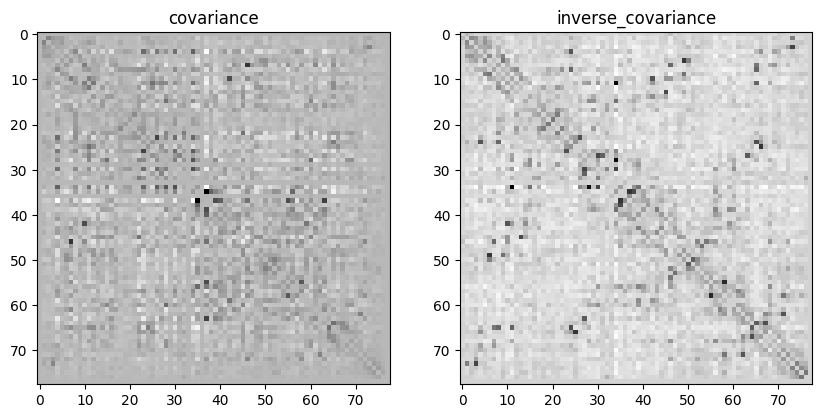

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("covariance")
plt.imshow(get_contacts(cov),cmap="gray_r")
plt.subplot(1,2,2); plt.title("inverse_covariance")
plt.imshow(get_contacts(inv_cov),cmap="gray_r")
plt.show()

In [84]:
@jax.jit
def evoformer_approx(key, m_si, z_ij=None, rate=0.5, heads=8):

  N,LA = m_si.shape

  # outer-product-mean-approx
  m_si_centered = m_si - m_si.mean(0)
  z_ij = (m_si_centered.T @ m_si_centered) / N

  # pair-weighted-averaging-approx
  r_ih = jax.random.normal(key, (LA,heads))
  v_ih = z_ij @ r_ih
  v_ih /= jnp.sqrt(jnp.square(v_ih).sum(0,keepdims=True))

  w_ij = v_ih @ v_ih.T / heads
  m_si_ = rate * m_si_centered @ w_ij

  # skip connection
  m_si = m_si - m_si_

  return m_si, z_ij

In [88]:
N,L,A = msa.shape
idx = jnp.triu_indices(L*A,1)
cons,auc = [],[]

m_si = msa.reshape(N,-1)
key = jax.random.PRNGKey(0)
for i in range(101):

  key, subkey = jax.random.split(key)
  m_si, z_ij = evoformer_approx(subkey, m_si, rate=0.5)

  auc.append(jnp.corrcoef(inv_cov[idx],z_ij[idx])[0,1])
  cons.append(get_contacts(z_ij))
  print(i,auc[-1])

0 0.44764864
1 0.5168988
2 0.5631008
3 0.600163
4 0.63532144
5 0.6604362
6 0.6750488
7 0.68826133
8 0.7031345
9 0.7170707
10 0.73207945
11 0.74183625
12 0.75074136
13 0.7606218
14 0.76875466
15 0.7795537
16 0.78706163
17 0.79442406
18 0.8006359
19 0.8058142
20 0.81006986
21 0.81427306
22 0.81827706
23 0.8250425
24 0.8292193
25 0.83335763
26 0.83707815
27 0.84030926
28 0.84409696
29 0.8485129
30 0.8513523
31 0.85385156
32 0.85667264
33 0.8596848
34 0.86286724
35 0.8656978
36 0.8677535
37 0.8702248
38 0.8723798
39 0.87412184
40 0.8766603
41 0.87846214
42 0.88021654
43 0.88203335
44 0.88387686
45 0.8848895
46 0.88661164
47 0.8882817
48 0.88998485
49 0.8912085
50 0.89254004
51 0.8942324
52 0.8955322
53 0.8966382
54 0.8979623
55 0.89917105
56 0.900207
57 0.9013486
58 0.9021543
59 0.90318984
60 0.9042304
61 0.9048542
62 0.9056501
63 0.90641177
64 0.90763557
65 0.90869695
66 0.9095543
67 0.91051793
68 0.91133845
69 0.9120291
70 0.91267747
71 0.9138773
72 0.91477925
73 0.91538423
74 0.9162309


Text(0, 0.5, 'correlation')

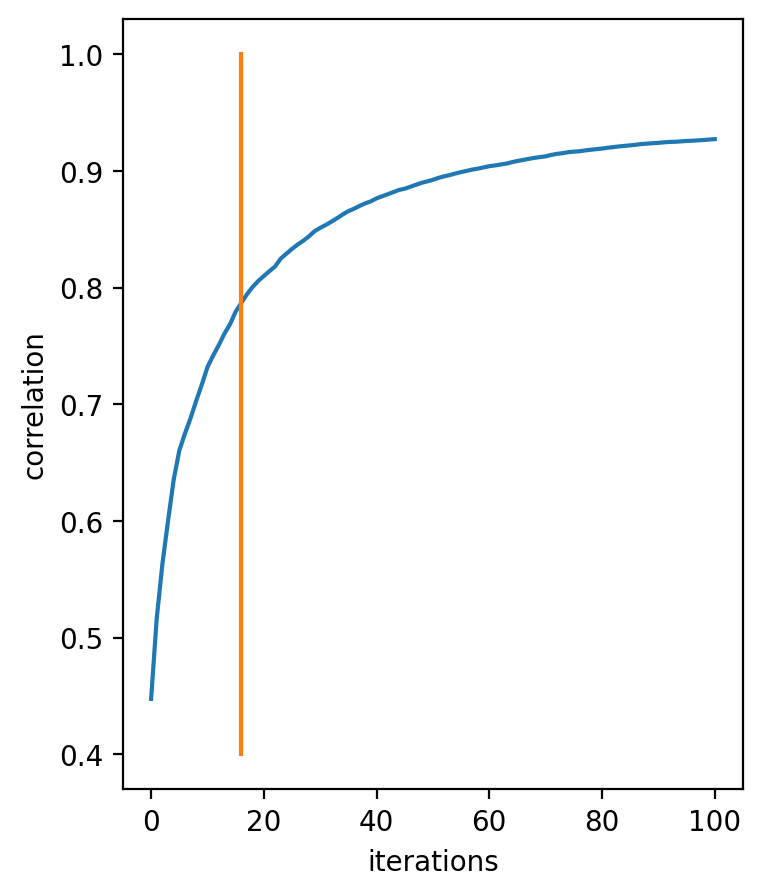

In [91]:
plt.figure(figsize=(4,5), dpi=200)
plt.plot(auc)
plt.plot([4*4,4*4],[0.4,1])
plt.xlabel("iterations")
plt.ylabel("correlation")

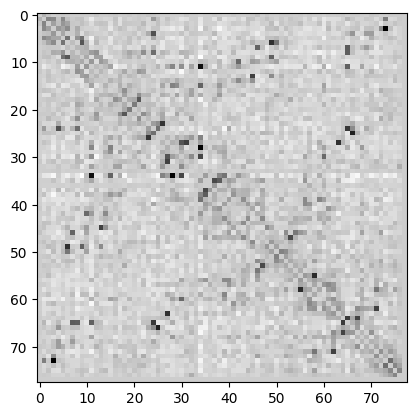

In [92]:
plt.imshow(-get_contacts(z_ij),cmap="gray")

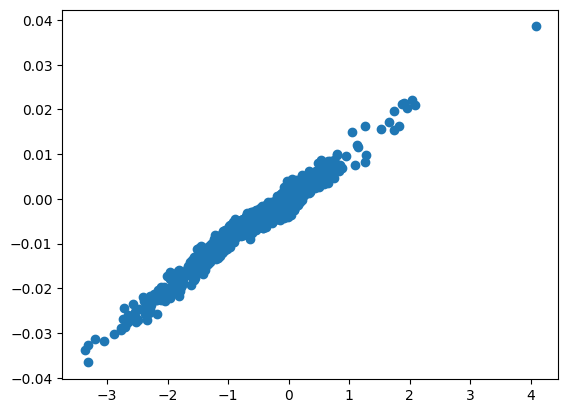

In [93]:
plt.scatter(inv_cov[idx],z_ij[idx])

In [94]:
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import matplotlib.patches as patches

def animate_heatmaps(X):
  fig, ax = plt.subplots()
  fig.set_figwidth(5);fig.set_figheight(5);fig.set_dpi(200)
  frames = []
  for k,x in enumerate(X):
    img = [ax.imshow(-x,
                     interpolation="none",
                     extent=(0, len(x), len(x), 0),
                     animated=True,
                     cmap="gray"),
           ax.text(0.5, 1.01, f"{k}", transform=ax.transAxes, ha='center')]
    frames.append(img)

  ani = ArtistAnimation(fig, frames, blit=True, interval=50)
  plt.close()
  return ani

In [95]:
HTML(animate_heatmaps(cons).to_html5_video())